# Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [2]:
import sys
sys.path.insert(0, '../src')
from cleaner import clean_text
%load_ext autoreload
%autoreload 2

In [23]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Data

In [4]:
df = pd.read_csv('../data/all_comments_with_sentiment.csv')

In [5]:
period_start = '2020-03-13' #inclusive
period_stop = '2020-03-20' #exclusive
df_pre = df[(df['date'] < period_stop) & (df['date'] >= period_start)]
df_pre.drop(columns=['Unnamed: 0','id','subreddit'],inplace=True)
df_pre.loc[:,'cleaned'] = df_pre['body'].apply(clean_text)
df_pre.dropna(axis=0,inplace=True)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

# LDA - Pre-launch

In [6]:
countvectorizer1 = CountVectorizer(
max_features = 1000
)

In [7]:
count_vec1 = countvectorizer1.fit_transform(df_pre['cleaned'])
count_vec1.shape

(93727, 1000)

# Grid Search

In [12]:
random_seed = 99
ldamodel1 = LatentDirichletAllocation(
    n_jobs = 1,
    learning_method='online',
    learning_decay = .75,
    random_state=random_seed
)

In [13]:
params = {
    'n_components': [2, 4, 6, 8, 10, 12],
#     'learning_decay': [0,7, 0.75, 0.80, 0.85]
}

lda_search1 = GridSearchCV(ldamodel,
                           param_grid=params,
                           cv=3,
                           return_train_score=False)

lda_search1.fit(count_vec1)

results1 = pd.DataFrame(lda_search1.cv_results_)

In [14]:
results1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,95.788691,3.768893,5.141310,0.163662,2,{'n_components': 2},-9.493709e+05,-1.083555e+06,-1.392004e+06,-1.141643e+06,185313.562933,1
1,95.656024,6.553862,5.127141,0.343642,4,{'n_components': 4},-9.712404e+05,-1.102965e+06,-1.414697e+06,-1.162967e+06,185945.658610,2
2,92.549711,4.985448,5.028001,0.259464,6,{'n_components': 6},-9.894887e+05,-1.121416e+06,-1.444263e+06,-1.185056e+06,191036.514147,3
3,88.447222,3.552780,4.883859,0.302601,8,{'n_components': 8},-1.002034e+06,-1.136525e+06,-1.460871e+06,-1.199810e+06,192590.446218,4
4,87.024555,2.858948,4.839702,0.222808,10,{'n_components': 10},-1.014917e+06,-1.142630e+06,-1.470395e+06,-1.209314e+06,191833.296778,5
5,86.563252,3.399180,4.735888,0.149571,12,{'n_components': 12},-1.022210e+06,-1.151684e+06,-1.486295e+06,-1.220063e+06,195534.545474,6


Text(0, 0.5, 'Log Likelihood')

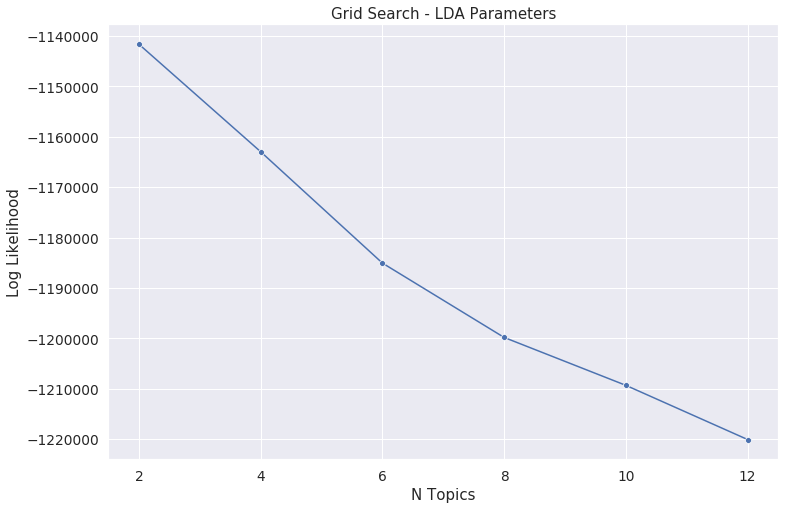

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=1.25)
sns.lineplot(data=results1,
             x='param_n_components',
             y='mean_test_score',
             marker='o'
            )
ax.set_title('Grid Search - LDA Parameters')
ax.set_xlabel('N Topics')
ax.set_ylabel('Log Likelihood')
# plt.savefig('../img/lda_gridsearch.png', bbox_inches = "tight")

# Model it again

In [30]:
random_seed = 99
ldamodel2 = LatentDirichletAllocation(
    n_components = 10,
    learning_method='online',
    learning_decay = .75,
    random_state=random_seed
)

In [31]:
ldamodel2.fit(count_vec1)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.75,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=99, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [32]:
p1 = pyLDAvis.sklearn.prepare(ldamodel2, count_vec1, countvectorizer1)

In [33]:
p1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.272034 -0.017980       1        1  16.345585
8     -0.246872 -0.137755       2        1  14.078382
9     -0.067320  0.136372       3        1  11.070947
0      0.254770 -0.066786       4        1  10.774293
7      0.199813 -0.113717       5        1   8.920113
5     -0.069640  0.037627       6        1   8.502156
3     -0.074912 -0.181780       7        1   8.227195
1      0.195039 -0.081630       8        1   8.171274
4      0.047382  0.041633       9        1   7.814758
6      0.033774  0.384016      10        1   6.095298, topic_info=         Term         Freq        Total Category  logprob  loglift
494      like  7762.000000  7762.000000  Default  30.0000  30.0000
936  villager  6089.000000  6089.000000  Default  29.0000  29.0000
314  favorite  5277.000000  5277.000000  Default  28.0000  28.0000
356      game  9663.000000  9663.000000  Default  27.0000  27.0000
39     animal  3664.000000  3664.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
405      head   278.569608   282.298771  Topic10  -4.7748   2.7844
70       back   906.206427  1680.991407  Topic10  -3.5952   2.1798
678    played   452.047411  1256.317490  Topic10  -4.2907   1.7755
770       see   388.443570  2210.886803  Topic10  -4.4423   1.0587
841     still   383.453437  2460.577983  Topic10  -4.4553   0.9387

[439 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.996022        able
0         6  0.003132        able
2         4  0.998900  absolutely
3         1  0.450496          ac
3         2  0.548828          ac
...     ...       ...         ...
991       6  0.999563        yeah
992       4  0.999344        year
994       3  0.999568         yes
996       2  0.320424         yet
996       3  0.678545         yet

[499 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 10, 1, 8, 6, 4, 2, 5, 7])

In [ ]:
pyLDAvis.save_html(p1, 'lda_prelaunch_all.html')